<a href="https://colab.research.google.com/github/sakurasakura1996/Pytorch-start-learning/blob/master/Dive_into_DL_pytorch_3_6_3_7_softmax%E5%9B%9E%E5%BD%92%E4%BB%8E%E9%9B%B6%E5%AE%9E%E7%8E%B0%E4%BB%A5%E5%8F%8A%E7%AE%80%E6%B4%81%E5%AE%9E%E7%8E%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 导入需要的模块
import torch
import numpy as np
import torchvision
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

In [3]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',download=True,train=True,transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',download=True,train=False,transform=transforms.ToTensor())




Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [0]:
# 获取数据集，并采用小批量
batch_size = 256
train_iter = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)
test_iter = torch.utils.data.DataLoader(dataset=mnist_test,batch_size=batch_size,shuffle=True,num_workers=4)

In [0]:
# 初始化模型参数
num_inputs = 28 * 28 
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01,(num_inputs,num_outputs)),dtype=torch.float)
b = torch.zeros(num_outputs,dtype=torch.float)


In [6]:
# 这些参数是要定义其梯度属性的
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [7]:
# 实现softmax运算
# 在介绍如何定义softmax回归之前，我们先描述一下如何对多维Tensor按维度操作。在下面例子中，给定一个Tensor矩阵X，我们可以只对其中同一列（dim=0) 或
# 同一行（dim=1）的元素求和，并在结果中保留行和列这两个维度（keepdim=True)
X = torch.tensor([[1, 2, 3],[4, 5, 6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))


tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


In [0]:
# 下面就可以定义前面小节里介绍的softmax运算了。X中每一行表示一个样本数据，列数是输出个数
def softmax(X):   # 这里的X已经是前向传播完成之后的了
  X_exp = X.exp()
  partition = X_exp.sum(dim=1,keepdim=True)
  return X_exp / partition   # 广播机制


In [9]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.1795, 0.2074, 0.2423, 0.1550, 0.2158],
        [0.1668, 0.2858, 0.1920, 0.1440, 0.2114]]) tensor([1.0000, 1.0000])


In [0]:
# 定义模型
# 通过view函数将每张原始图像改成长度为 num_inputs的向量
def net(X):
  return softmax(torch.mm(X.view(-1,num_inputs),W)+b)

In [11]:
# 定义损失函数
# softmax回归使用的交叉熵损失函数.为了得到标签的预测概率，我们可以使用gather函数。在下面的例子中，通过gather函数根据每行真实值label的索引将预测值取出来
y_hat = torch.tensor([[0.1, 0.2, 0.7],[0.3, 0.3, 0.4]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))
# 看这个示例程序应该能懂gather函数是干嘛的了吧。y_hat也就是前向传播之后并进行softmax之后的结果，y就是每行实际label所在的索引。gather就是根据索引找到y_hat对应的值

tensor([[0.1000],
        [0.4000]])

In [0]:
def cross_entropy(y_hat, y):
  return - torch.log(y_hat.gather(1, y.view(-1, 1)))


In [0]:
# 计算分类准确率
# 分类准确率就是正确预测数量与总预测数量之比
def accuracy(y_hat, y):
  return (y_hat.argmax(dim=1) == y).float().mean().item()

# y_hat.argmax(dim=1) 返回矩阵y_hat中每行最大元素值所在的索引，返回结果与y同形状， 然后 ==y 返回一个tensor，类型为 ByteTensor，利用float()
# 转换为值为0（相等为假）的浮点型tensor 

In [16]:
print(accuracy(y_hat,y))

0.5


In [0]:
# 类似的，我们可以评价模型net在数据集data_iter上的准确率
def evaluate_accuracy(data_iter, net):
  acc_sum, n = 0.0, 0
  for X, y in data_iter:
    acc_sum += (net(X).argmax(dim=1)==y).float().sum().item()
    n += y.shape[0]
  return acc_sum / n

In [18]:
print(evaluate_accuracy(test_iter, net))

0.1123


In [0]:
# 3.6.7 训练模型

lr = 0.05
num_epochs = 5

def sgd(params, lr, batch_size):
  # params也就是网络中带训练的参数，是一个列表性质的
  for param in params:
    param.data -= lr * param.grad / batch_size


def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
      y_hat=net(X)
      l = loss(y_hat, y).sum()

      # 梯度清零
      if optimizer is not None:
        optimizer.zero_grad()
      elif params is not None and params[0].grad is not None:
        for param in params:
          param.grad.data.zero_()
      
      l.backward()
      if optimizer is None:
        sgd(params, lr, batch_size)
      else:
        optimizer.step()    # 这是pytorch中封装好的好东西
      
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(dim=1)==y).float().sum().item()
      n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter, net)
    print("epoch : %d , loss : %.4f, train acc : %.3f, test acc : %.3f" % (epoch+1, train_l_sum / n, train_acc_sum / n, test_acc ))


In [25]:
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W,b], lr)

epoch : 1 , loss : 0.9109, train acc : 0.724, test acc : 0.766
epoch : 2 , loss : 0.6396, train acc : 0.797, test acc : 0.791
epoch : 3 , loss : 0.5811, train acc : 0.813, test acc : 0.806
epoch : 4 , loss : 0.5490, train acc : 0.821, test acc : 0.812
epoch : 5 , loss : 0.5283, train acc : 0.826, test acc : 0.815


In [0]:
def get_fashion_mnist_labels(labels):
  """
  根据labels数值来返回它所代表的类别 str
  """
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress','coat','sandal', 'shirt', 'sneaker', 'bag', 'ankleboot']
  # return text_labels[labels] # 明显这个函数定义的太低级了吧。现在将输入改成labels ->一整个数据集的labels啊也就是一个列表
  return [text_labels[int(i)] for i in labels]

In [0]:
def show_fashion_mnist(images, labels):
  _, figs = plt.subplots(1, len(images), figsize=(15,15))
  for f, img, lbl in zip(figs, images, labels):
    f.imshow(img.view((28,28)).numpy())
    f.set_title(lbl)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
  plt.show()

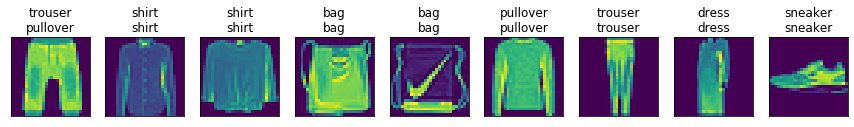

In [32]:
# 预测
X ,y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels,pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])

In [0]:
# 3.7 softmax回归的简洁实现， 这里用pytorch给我们提供的一些工具包来同样实现一遍softmax回归
from torch import nn
from torch.nn import init
# batch_size 和 获取数据集同上面是一样的，这里直接用上面的了
# batch_size = 256
# train_iter, test_iter 

In [0]:
# 定义和初始化模型
class LinearNet(nn.Module):
  def __init__(self, num_inputs, num_outputs):
    super(LinearNet, self).__init__()
    self.linear = nn.Linear(num_inputs, num_outputs)
  
  def forward(self, x):   # x shape: (batch, 1, 28, 28)
    y = self.linear(x.view(x.shape[0],-1))
    return y

net = LinearNet(num_inputs, num_outputs)


In [0]:
class FlattenLayer(nn.Module):
  def __init__(self):
    super(FlattenLayer, self).__init__()
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [0]:
from collections import OrderedDict
# 定义我们的模型
net = nn.Sequential(
    # FlattenLayer(),
    # nn.Linear(num_inputs, num_outputs)
    OrderedDict([
      ('flatten', FlattenLayer()),
      ('linear', nn.Linear(num_inputs, num_outputs))])
    )

In [39]:
# 我们使用均值为0， 标准差为0.01的正态分布随机初始化模型的权重参数
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [0]:
# softmax 和 交叉熵损失函数，pytorch提供了一个包括softmax运算和交叉熵损失计算的函数，数值稳定性更好
loss = nn.CrossEntropyLoss()

In [0]:
# 定义优化算法
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)


In [42]:
# 训练模型
num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch : 1 , loss : 0.0031, train acc : 0.749, test acc : 0.785
epoch : 2 , loss : 0.0022, train acc : 0.812, test acc : 0.799
epoch : 3 , loss : 0.0021, train acc : 0.825, test acc : 0.816
epoch : 4 , loss : 0.0020, train acc : 0.832, test acc : 0.816
epoch : 5 , loss : 0.0019, train acc : 0.837, test acc : 0.823
